In [ ]:
import os
import shutil
import warnings
import csv
import yaml
import json
import torch

from PIL import Image
import pandas as pd
import numpy as np
from typing import Any, Sequence

from os import PathLike
from torch.utils.data import Dataset

from megadetector.detection.run_detector import load_detector, model_string_to_model_version
from megadetector.detection.run_detector_batch import process_images, write_results_to_file


from sklearn.model_selection import train_test_split

In [15]:
import torch
print(torch.__version__)

import torchvision
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [1]:
import random

from pathlib import Path

from ba_dev.dataset import MammaliaData, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_config_yaml

paths = load_config_yaml('../path_config.yml')


### Running Tests

In [2]:
path_to_dataset = paths['dataset']
path_labelfiles = paths['test_labels']
path_to_detector_output = paths['md_output']
detector_model='mdv5a'
mode='train'

dataset = MammaliaDataImage(
    path_labelfiles=path_labelfiles,
    path_to_dataset=path_to_dataset,
    path_to_detector_output=path_to_detector_output,
    detector_model=detector_model,
    mode=mode,
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:212: UserWarning: With the detection confidence of 0.25,
8 sequences had no detections and will be excluded.
Excluded sequences: [6000161, 6000163, 6000293, 6000530, 6000691, 6000372, 6000953, 6000186]
  warnings.warn(


In [10]:
pipline = BatchImagePipeline(
                num_workers=2,
                path_to_dataset=path_to_dataset,
                steps = [
                    ('to_rgb', {}),
                    ('crop_by_bb', {}),
                    ('resize', {'size': 224}),
                    ('to_tensor', {})
                ]
            )

In [4]:
list_of_paths = []
list_of_bboxes = []

samples = [random.randint(0, len(dataset)) for _ in range(8)]

for i in samples:
    row = dataset[i]

    list_of_paths.append(row['file_path'])
    list_of_bboxes.append(row['bbox'])


In [11]:
results = pipline(list_of_paths, list_of_bboxes)

In [13]:
for result in results:
    print(result)

tensor([[[0.3804, 0.3843, 0.3922,  ..., 0.1765, 0.1725, 0.1725],
         [0.3843, 0.3882, 0.3961,  ..., 0.1765, 0.1725, 0.1725],
         [0.3922, 0.3922, 0.4000,  ..., 0.1765, 0.1725, 0.1725],
         ...,
         [0.9490, 0.9882, 1.0000,  ..., 0.1373, 0.1255, 0.0863],
         [0.9451, 0.9647, 1.0000,  ..., 0.1294, 0.1137, 0.0745],
         [0.9529, 0.9412, 0.9922,  ..., 0.1176, 0.1020, 0.0784]],

        [[0.4353, 0.4392, 0.4314,  ..., 0.2000, 0.1961, 0.1922],
         [0.4314, 0.4353, 0.4275,  ..., 0.2000, 0.1961, 0.1922],
         [0.4235, 0.4235, 0.4157,  ..., 0.2000, 0.1961, 0.1961],
         ...,
         [0.8392, 0.8706, 0.8824,  ..., 0.1373, 0.1333, 0.0902],
         [0.8392, 0.8471, 0.8706,  ..., 0.1373, 0.1216, 0.0784],
         [0.8549, 0.8392, 0.8745,  ..., 0.1255, 0.1137, 0.0902]],

        [[0.3765, 0.3804, 0.3843,  ..., 0.1843, 0.1843, 0.1882],
         [0.3765, 0.3765, 0.3843,  ..., 0.1843, 0.1843, 0.1882],
         [0.3725, 0.3725, 0.3804,  ..., 0.1843, 0.1804, 0.

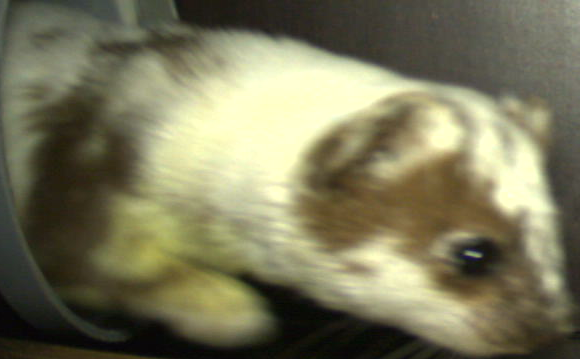

In [4]:
sample = dataset[0]
image_path = dataset.path_to_dataset / sample['file_path']
bbox = sample['bbox']

image = pipline(image_path, bbox)
image.show()

In [13]:
labelfiles = dataset.get_all_files_of_type(path=paths['labels'], file_type='csv')

In [14]:
metadata = dataset.reading_all_metadata(
    list_of_files=labelfiles,
)

In [16]:
metadata[metadata['label2']=='other']

,session,SerialNumber,seq_nr,seq_id,Directory,...,n_files,all_files,label,duplicate_label,label2
544,1,H550HF07158873,233,1000588,sessions/session_01/H550HF07158873_2,...,24,"IMG_3754.JPG,IMG_3755.JPG,IMG_3756.JPG,IMG_375...","apodemus_sp,myodes_glareolus",1.0,other
1364,1,H550HF07158933,26,1001428,sessions/session_01/H550HF07158933_2,...,6,"IMG_0136.JPG,IMG_0137.JPG,IMG_0138.JPG,IMG_013...","apodemus_sp,myodes_glareolus",1.0,other
1400,1,H550HF07158933,66,1001468,sessions/session_01/H550HF07158933_1,...,9,"IMG_0175.JPG,IMG_0176.JPG,IMG_0177.JPG,IMG_017...","myodes_glareolus,crocidura_sp",1.0,other
1498,1,H550HF07158933,173,1001575,sessions/session_01/H550HF07158933_1,...,9,"IMG_0778.JPG,IMG_0779.JPG,IMG_0780.JPG,IMG_078...","apodemus_sp,crocidura_sp",1.0,other
2766,1,H550HF08161376,330,1002883,sessions/session_01/H550HF08161376_1,...,6,"IMG_1861.JPG,IMG_1862.JPG,IMG_1863.JPG,IMG_186...","microtus_sp,apodemus_sp",1.0,other
...,...,...,...,...,...,...,...,...,...,...,...
20438,4,H550HF07158933,99,4018333,sessions/session_04/W7-WK02,...,30,"IMG_2410.JPG,IMG_2411.JPG,IMG_2412.JPG,IMG_241...","myodes_glareolus,crocidura_sp",1.0,other
20535,4,H550HF07158933,205,4018439,sessions/session_04/W7-WK02,...,12,"IMG_3979.JPG,IMG_3980.JPG,IMG_3981.JPG,IMG_398...","myodes_glareolus,crocidura_sp",1.0,other
20700,4,H550HF08161368,162,4018611,sessions/session_04/W7-WK06,...,33,"IMG_3214.JPG,IMG_3215.JPG,IMG_3216.JPG,IMG_321...","crocidura_sp,sorex_sp",1.0,other
20706,4,H550HF08161368,168,4018617,sessions/session_04/W7-WK06,...,18,"IMG_3331.JPG,IMG_3332.JPG,IMG_3333.JPG,IMG_333...","myodes_glareolus,apodemus_sp",1.0,other


In [10]:
sequences = metadata['seq_id'].tolist()

In [11]:
sequences

[1000001,
 1000002,
 1000003,
 1000004,
 1000005,
 1000006,
 1000008,
 1000009,
 1000011,
 1000015,
 1000016,
 1000018,
 1000019,
 1000020,
 1000021,
 1000022,
 1000023,
 1000024,
 1000025,
 1000026,
 1000027,
 1000028,
 1000029,
 1000030,
 1000031,
 1000032,
 1000033,
 1000034,
 1000035,
 1000036,
 1000037,
 1000038,
 1000039,
 1000040,
 1000041,
 1000042,
 1000043,
 1000044,
 1000045,
 1000046,
 1000047,
 1000048,
 1000049,
 1000050,
 1000051,
 1000052,
 1000053,
 1000054,
 1000055,
 1000056,
 1000057,
 1000058,
 1000059,
 1000060,
 1000061,
 1000062,
 1000063,
 1000064,
 1000065,
 1000066,
 1000067,
 1000068,
 1000069,
 1000070,
 1000071,
 1000072,
 1000073,
 1000074,
 1000075,
 1000076,
 1000077,
 1000078,
 1000079,
 1000080,
 1000081,
 1000082,
 1000083,
 1000084,
 1000085,
 1000086,
 1000087,
 1000088,
 1000089,
 1000090,
 1000091,
 1000092,
 1000093,
 1000094,
 1000095,
 1000096,
 1000097,
 1000098,
 1000099,
 1000100,
 1000101,
 1000102,
 1000103,
 1000104,
 1000105,
 1000106,


In [12]:
row = metadata.loc[metadata['seq_id'] == 1000001]

In [16]:
row['Directory'].item()

'sessions/session_01/H_2'

In [22]:
row['all_files'][0].split(",")

['RCNX0005.JPG',
 'RCNX0006.JPG',
 'RCNX0007.JPG',
 'RCNX0009.JPG',
 'RCNX0010.JPG',
 'RCNX0011.JPG']

In [14]:
counter = 0
for seq in sequences:
    current_seq = seq
    counter += 1
    seq_images = dataset.get_all_images_of_sequence(seq, dataframe=metadata)

In [15]:
counter

22300

In [9]:
current_seq

1000001

In [9]:
path_to_dataset = paths['dataset']
path_labelfiles = Path('/Volumes/ExSSD/UserData/BA_Data/dataset/info/testlabel') #paths['testset']
path_to_detector_output = path_labelfiles / 'md_out77'
detector_model = 'mdv5a'
mode = 'init'

dataset = MammaliaData(
    path_to_dataset = path_to_dataset,
    path_labelfiles = path_labelfiles,
    path_to_detector_output = path_to_detector_output,
    detector_model = detector_model,
    mode = mode,
    )

Bypassing download of already-downloaded file md_v5a.0.0.pt
Model v5a.0.0 available at /var/folders/t0/5px6w93n5rvdnqbxvt4n6qf00000gn/T/megadetector_models/md_v5a.0.0.pt
Bypassing imports for model type yolov5
Loading PT detector with compatibility mode classic


Fusing layers... 
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


ValueError: No sequence with seq_id=1000588 found.